In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd


EXPERIMENT = 'cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 100

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 4 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.3 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-3,3)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
HIST_MATCHING = False
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10
Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-03-16 12:32:14,045 INFO -------------------- Start --------------------
2021-03-16 12:32:14,046 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-03-16 12:32:14,046 INFO Log file: ./logs/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8.log
2021-03-16 12:32:14,046 INFO Log level for console: INFO
2021-03-16 12:32:14,047 INFO Is built with tensorflow: True
2021-03-16 12:32:14,272 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32', 'MODEL_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model', 'TENSORBOARD_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/tensorboard_logs', 'CONFIG_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/config', 'HISTORY_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/', 'DF_FOLDS': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv', 'DF_META': '/mnt/ssd/data/gcn/02

2021-03-16 12:32:15,128 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2583961236089907562
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13178581378010783706
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12299847318253431585
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17068087413201392319
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23082897280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16749408497153762319
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23561682304
locality {
  bus

In [2]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-03-16 12:32:15,151 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-03-16 12:32:15,160 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-03-16 12:32:15,161 INFO Patients train: 209
2021-03-16 12:32:15,172 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-03-16 12:32:15,172 INFO SAX train CMR: 209, SAX train masks: 209
2021-03-16 12:32:15,173 INFO SAX val CMR: 69, SAX val masks: 69


In [3]:
# check if we find each patient in the corresponding dataframe
import re
import pandas as pd
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

In [4]:
files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))
info('Done!')

2021-03-16 12:32:15,224 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-03-16 12:32:15,493 INFO Done!


In [5]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [6]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-03-16 12:32:15,553 INFO Create DataGenerator
2021-03-16 12:32:15,554 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 209 
 Augment: True 
 Thread workers: 8
2021-03-16 12:32:15,555 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-03-16 12:32:15,577 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-16 12:32:15,578 INFO Temporal phase augmentation: 
True
Repeat volume: 
True
2021-03-16 12:32:15,650 INFO Create DataGenerator
2021-03-16 12:32:15,650 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 69 
 Augment: False 
 Thread workers: 8
2021-03-16 12:32:15,651 INFO No augmentation
2021-03-16 12:32:15,663 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-16 12:32:15,664 INFO Temporal phase augmentation: 
False
Repeat volume: 
True


In [7]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
        """f, axs = plt.subplots(1,2,figsize=(12,4))
        i = 0
        temp_y = selected_output
        print(np.sum(temp_y, axis=1))

        # ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0) # before we had the gt mask
        ind_gt = np.argmax(temp_y * selected_gt_len_msk, axis=1)
        axs[0].title.set_text('y')
        axs[0].set_xticks(ind_gt, minor=False)
        axs[0].set_yticks([0,1,2,3,4], minor=False)
        axs[0].set_yticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto', )
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()"""
    
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))


interactive(children=(IntSlider(value=13, description='batch', max=26), IntSlider(value=3, description='im', m…

In [8]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)"""

'for b in range(len(batch_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)'

In [9]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

Shape after the temporal encoder
(None, 36, 8, 4, 4, 512)
Shape after GAP
(None, 36, 512)
Shape after Bi-LSTM layer
(None, 36, 512)
Shape after final conv layer
(None, 36, 5)


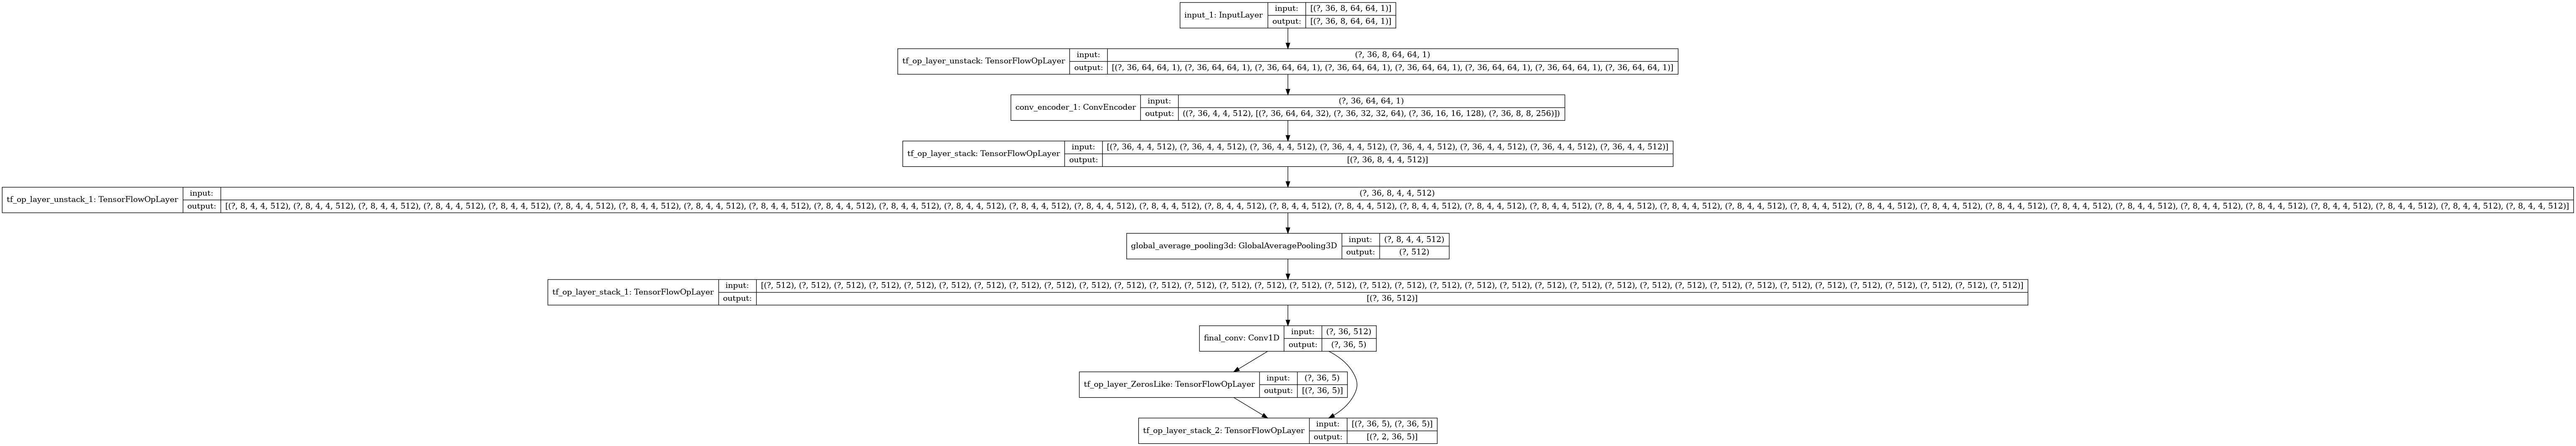

In [10]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

In [ ]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-03-16 12:32:20,365 INFO feed 4 Tensorboard is ready


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.1545 - mse_wrapper: 1.1545 - ca_wrapper: 0.4135 - meandiff: 13.5385

2021-03-16 12:33:29,367 INFO (4, 2, 36, 5)
2021-03-16 12:33:29,953 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 1.15449, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 36s 1s/step - loss: 1.1545 - mse_wrapper: 1.1545 - ca_wrapper: 0.4135 - meandiff: 13.5385 - val_loss: 2.5297 - val_mse_wrapper: 2.5297 - val_ca_wrapper: 0.3264 - val_meandiff: 14.9688 - lr: 1.0000e-04
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.8478 - mse_wrapper: 0.8478 - ca_wrapper: 0.5845 - meandiff: 9.2933

2021-03-16 12:34:02,355 INFO (4, 2, 36, 5)
2021-03-16 12:34:02,907 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 1.15449 to 0.84781, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8478 - mse_wrapper: 0.8478 - ca_wrapper: 0.5845 - meandiff: 9.2933 - val_loss: 1.7855 - val_mse_wrapper: 1.7855 - val_ca_wrapper: 0.5143 - val_meandiff: 8.2031 - lr: 1.0000e-04
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.7977 - mse_wrapper: 0.7977 - ca_wrapper: 0.6480 - meandiff: 8.2596

2021-03-16 12:34:35,336 INFO (4, 2, 36, 5)
2021-03-16 12:34:35,859 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 0.84781 to 0.79773, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7977 - mse_wrapper: 0.7977 - ca_wrapper: 0.6480 - meandiff: 8.2596 - val_loss: 1.3162 - val_mse_wrapper: 1.3162 - val_ca_wrapper: 0.5946 - val_meandiff: 6.4844 - lr: 1.0000e-04
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 0.7010 - mse_wrapper: 0.7010 - ca_wrapper: 0.7131 - meandiff: 6.9952

2021-03-16 12:35:08,526 INFO (4, 2, 36, 5)
2021-03-16 12:35:09,048 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 0.79773 to 0.70103, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7010 - mse_wrapper: 0.7010 - ca_wrapper: 0.7131 - meandiff: 6.9952 - val_loss: 0.8441 - val_mse_wrapper: 0.8441 - val_ca_wrapper: 0.6745 - val_meandiff: 7.3594 - lr: 1.0000e-04
Epoch 5/100
26/26 [==============================] - ETA: 0s - loss: 0.6637 - mse_wrapper: 0.6637 - ca_wrapper: 0.7409 - meandiff: 6.3173
Epoch 00005: loss improved from 0.70103 to 0.66366, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.6637 - mse_wrapper: 0.6637 - ca_wrapper: 0.7409 - meandiff: 6.3173 - val_loss: 1.0392 - val_mse_wrapper: 1.0392 - val_ca_wrapper: 0.7014 - val_meandiff: 5.8125 - lr: 1.0000e-04
Epoch 6/100

2021-03-16 12:36:16,190 INFO (4, 2, 36, 5)
2021-03-16 12:36:16,707 INFO (4, 2, 36, 5)



Epoch 00006: loss improved from 0.66366 to 0.62752, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.6275 - mse_wrapper: 0.6275 - ca_wrapper: 0.7465 - meandiff: 6.1875 - val_loss: 1.0326 - val_mse_wrapper: 1.0326 - val_ca_wrapper: 0.7500 - val_meandiff: 5.0938 - lr: 1.0000e-04
Epoch 7/100
26/26 [==============================] - ETA: 0s - loss: 0.6069 - mse_wrapper: 0.6069 - ca_wrapper: 0.7508 - meandiff: 5.6587
Epoch 00007: loss improved from 0.62752 to 0.60691, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.6069 - mse_wrapper: 0.6069 - ca_wrapper: 0.7508 - meandiff: 5.6587 - val_loss: 1.2875 - val_mse_wrapper: 1.2875 - val_ca_wrapper: 0.6224 - val_meandiff: 9.1719 - lr: 1.0000e-04
Epoch 8/100

2021-03-16 12:37:26,121 INFO (4, 2, 36, 5)
2021-03-16 12:37:26,938 INFO (4, 2, 36, 5)



Epoch 00008: loss improved from 0.60691 to 0.58339, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.5834 - mse_wrapper: 0.5834 - ca_wrapper: 0.7670 - meandiff: 5.2500 - val_loss: 0.9826 - val_mse_wrapper: 0.9826 - val_ca_wrapper: 0.7322 - val_meandiff: 5.1562 - lr: 1.0000e-04
Epoch 9/100
26/26 [==============================] - ETA: 0s - loss: 0.5610 - mse_wrapper: 0.5610 - ca_wrapper: 0.7778 - meandiff: 4.8750
Epoch 00009: loss improved from 0.58339 to 0.56104, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.5610 - mse_wrapper: 0.5610 - ca_wrapper: 0.7778 - meandiff: 4.8750 - val_loss: 0.7277 - val_mse_wrapper: 0.7277 - val_ca_wrapper: 0.7826 - val_meandiff: 4.4688 - lr: 1.0000e-04
Epoch 10/10

2021-03-16 12:38:36,544 INFO (4, 2, 36, 5)
2021-03-16 12:38:37,065 INFO (4, 2, 36, 5)



Epoch 00010: loss improved from 0.56104 to 0.54270, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.5427 - mse_wrapper: 0.5427 - ca_wrapper: 0.7925 - meandiff: 4.6923 - val_loss: 0.9357 - val_mse_wrapper: 0.9357 - val_ca_wrapper: 0.7274 - val_meandiff: 4.7500 - lr: 1.0000e-04
Epoch 11/100
26/26 [==============================] - ETA: 0s - loss: 0.5228 - mse_wrapper: 0.5228 - ca_wrapper: 0.7907 - meandiff: 4.6875
Epoch 00011: loss improved from 0.54270 to 0.52279, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.5228 - mse_wrapper: 0.5228 - ca_wrapper: 0.7907 - meandiff: 4.6875 - val_loss: 0.7582 - val_mse_wrapper: 0.7582 - val_ca_wrapper: 0.7839 - val_meandiff: 4.3125 - lr: 1.0000e-04
Epoch 12/1

2021-03-16 12:39:47,025 INFO (4, 2, 36, 5)
2021-03-16 12:39:47,581 INFO (4, 2, 36, 5)



Epoch 00012: loss did not improve from 0.52279
26/26 [==============================] - 34s 1s/step - loss: 0.5314 - mse_wrapper: 0.5314 - ca_wrapper: 0.7949 - meandiff: 4.7452 - val_loss: 0.8982 - val_mse_wrapper: 0.8982 - val_ca_wrapper: 0.7687 - val_meandiff: 4.6875 - lr: 1.0000e-04
Epoch 13/100
26/26 [==============================] - ETA: 0s - loss: 0.5105 - mse_wrapper: 0.5105 - ca_wrapper: 0.7966 - meandiff: 4.4327
Epoch 00013: loss improved from 0.52279 to 0.51048, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.5105 - mse_wrapper: 0.5105 - ca_wrapper: 0.7966 - meandiff: 4.4327 - val_loss: 0.9670 - val_mse_wrapper: 0.9670 - val_ca_wrapper: 0.7713 - val_meandiff: 5.0000 - lr: 1.0000e-04
Epoch 14/100
26/26 [==============================] - ETA: 0s - loss: 0.5050 - mse_wrapper: 0.5050 - ca_wrapper: 0.8056 - meandiff: 4.3750

2021-03-16 12:40:57,652 INFO (4, 2, 36, 5)
2021-03-16 12:40:58,219 INFO (4, 2, 36, 5)



Epoch 00014: loss improved from 0.51048 to 0.50496, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.5050 - mse_wrapper: 0.5050 - ca_wrapper: 0.8056 - meandiff: 4.3750 - val_loss: 1.5338 - val_mse_wrapper: 1.5338 - val_ca_wrapper: 0.6936 - val_meandiff: 4.4844 - lr: 1.0000e-04
Epoch 15/100
26/26 [==============================] - ETA: 0s - loss: 0.4908 - mse_wrapper: 0.4908 - ca_wrapper: 0.8026 - meandiff: 4.1779
Epoch 00015: loss improved from 0.50496 to 0.49085, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4908 - mse_wrapper: 0.4908 - ca_wrapper: 0.8026 - meandiff: 4.1779 - val_loss: 0.6638 - val_mse_wrapper: 0.6638 - val_ca_wrapper: 0.8012 - val_meandiff: 4.2969 - lr: 1.0000e-04
Epoch 16/1

2021-03-16 12:42:08,124 INFO (4, 2, 36, 5)
2021-03-16 12:42:08,677 INFO (4, 2, 36, 5)



Epoch 00016: loss improved from 0.49085 to 0.48954, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4895 - mse_wrapper: 0.4895 - ca_wrapper: 0.8077 - meandiff: 4.2067 - val_loss: 0.6904 - val_mse_wrapper: 0.6904 - val_ca_wrapper: 0.8038 - val_meandiff: 4.6250 - lr: 1.0000e-04
Epoch 17/100
26/26 [==============================] - ETA: 0s - loss: 0.4766 - mse_wrapper: 0.4766 - ca_wrapper: 0.8090 - meandiff: 3.9423
Epoch 00017: loss improved from 0.48954 to 0.47665, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4766 - mse_wrapper: 0.4766 - ca_wrapper: 0.8090 - meandiff: 3.9423 - val_loss: 0.7590 - val_mse_wrapper: 0.7590 - val_ca_wrapper: 0.7917 - val_meandiff: 3.7969 - lr: 1.0000e-04
Epoch 18/1

2021-03-16 12:43:19,562 INFO (4, 2, 36, 5)
2021-03-16 12:43:20,108 INFO (4, 2, 36, 5)



Epoch 00018: loss improved from 0.47665 to 0.46902, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.4690 - mse_wrapper: 0.4690 - ca_wrapper: 0.8160 - meandiff: 4.1010 - val_loss: 0.9550 - val_mse_wrapper: 0.9550 - val_ca_wrapper: 0.8099 - val_meandiff: 4.0156 - lr: 1.0000e-04
Epoch 19/100
26/26 [==============================] - ETA: 0s - loss: 0.4737 - mse_wrapper: 0.4737 - ca_wrapper: 0.8108 - meandiff: 4.3702
Epoch 00019: loss did not improve from 0.46902
26/26 [==============================] - 33s 1s/step - loss: 0.4737 - mse_wrapper: 0.4737 - ca_wrapper: 0.8108 - meandiff: 4.3702 - val_loss: 0.9203 - val_mse_wrapper: 0.9203 - val_ca_wrapper: 0.7491 - val_meandiff: 4.2969 - lr: 1.0000e-04
Epoch 20/100
26/26 [==============================] - ETA: 0s - loss: 0.4768 - mse_wrapper: 0.4768 - ca_wrapper: 0.8101 - meandiff: 4.2452

2021-03-16 12:44:30,424 INFO (4, 2, 36, 5)
2021-03-16 12:44:30,974 INFO (4, 2, 36, 5)



Epoch 00020: loss did not improve from 0.46902
26/26 [==============================] - 34s 1s/step - loss: 0.4768 - mse_wrapper: 0.4768 - ca_wrapper: 0.8101 - meandiff: 4.2452 - val_loss: 0.7442 - val_mse_wrapper: 0.7442 - val_ca_wrapper: 0.7604 - val_meandiff: 4.3750 - lr: 1.0000e-04
Epoch 21/100
26/26 [==============================] - ETA: 0s - loss: 0.4593 - mse_wrapper: 0.4593 - ca_wrapper: 0.8116 - meandiff: 3.9615
Epoch 00021: loss improved from 0.46902 to 0.45926, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4593 - mse_wrapper: 0.4593 - ca_wrapper: 0.8116 - meandiff: 3.9615 - val_loss: 0.7100 - val_mse_wrapper: 0.7100 - val_ca_wrapper: 0.8168 - val_meandiff: 4.0781 - lr: 1.0000e-04
Epoch 22/100
26/26 [==============================] - ETA: 0s - loss: 0.4486 - mse_wrapper: 0.4486 - ca_wrapper: 0.8164 - meandiff: 4.1250

2021-03-16 12:45:40,746 INFO (4, 2, 36, 5)
2021-03-16 12:45:41,309 INFO (4, 2, 36, 5)



Epoch 00022: loss improved from 0.45926 to 0.44861, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4486 - mse_wrapper: 0.4486 - ca_wrapper: 0.8164 - meandiff: 4.1250 - val_loss: 0.7949 - val_mse_wrapper: 0.7949 - val_ca_wrapper: 0.7977 - val_meandiff: 4.2031 - lr: 1.0000e-04
Epoch 23/100
26/26 [==============================] - ETA: 0s - loss: 0.4544 - mse_wrapper: 0.4544 - ca_wrapper: 0.8213 - meandiff: 3.8798
Epoch 00023: loss did not improve from 0.44861
26/26 [==============================] - 32s 1s/step - loss: 0.4544 - mse_wrapper: 0.4544 - ca_wrapper: 0.8213 - meandiff: 3.8798 - val_loss: 0.6908 - val_mse_wrapper: 0.6908 - val_ca_wrapper: 0.7938 - val_meandiff: 4.0469 - lr: 1.0000e-04
Epoch 24/100
26/26 [==============================] - ETA: 0s - loss: 0.4402 - mse_wrapper: 0.4402 - ca_wrapper: 0.8268 - meandiff: 3.7356

2021-03-16 12:46:50,689 INFO (4, 2, 36, 5)
2021-03-16 12:46:51,247 INFO (4, 2, 36, 5)



Epoch 00024: loss improved from 0.44861 to 0.44018, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4402 - mse_wrapper: 0.4402 - ca_wrapper: 0.8268 - meandiff: 3.7356 - val_loss: 0.7260 - val_mse_wrapper: 0.7260 - val_ca_wrapper: 0.7990 - val_meandiff: 4.4844 - lr: 1.0000e-04
Epoch 25/100
26/26 [==============================] - ETA: 0s - loss: 0.4342 - mse_wrapper: 0.4342 - ca_wrapper: 0.8225 - meandiff: 3.6779
Epoch 00025: loss improved from 0.44018 to 0.43420, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4342 - mse_wrapper: 0.4342 - ca_wrapper: 0.8225 - meandiff: 3.6779 - val_loss: 0.6758 - val_mse_wrapper: 0.6758 - val_ca_wrapper: 0.7765 - val_meandiff: 3.9219 - lr: 1.0000e-04
Epoch 26/1

2021-03-16 12:48:01,208 INFO (4, 2, 36, 5)
2021-03-16 12:48:01,766 INFO (4, 2, 36, 5)



Epoch 00026: loss did not improve from 0.43420
26/26 [==============================] - 34s 1s/step - loss: 0.4365 - mse_wrapper: 0.4365 - ca_wrapper: 0.8205 - meandiff: 3.8702 - val_loss: 0.7939 - val_mse_wrapper: 0.7939 - val_ca_wrapper: 0.7834 - val_meandiff: 4.2344 - lr: 1.0000e-04
Epoch 27/100
26/26 [==============================] - ETA: 0s - loss: 0.4365 - mse_wrapper: 0.4365 - ca_wrapper: 0.8233 - meandiff: 3.7788
Epoch 00027: loss did not improve from 0.43420
26/26 [==============================] - 32s 1s/step - loss: 0.4365 - mse_wrapper: 0.4365 - ca_wrapper: 0.8233 - meandiff: 3.7788 - val_loss: 0.8113 - val_mse_wrapper: 0.8113 - val_ca_wrapper: 0.8095 - val_meandiff: 3.5938 - lr: 1.0000e-04
Epoch 28/100
26/26 [==============================] - ETA: 0s - loss: 0.4223 - mse_wrapper: 0.4223 - ca_wrapper: 0.8328 - meandiff: 3.8173

2021-03-16 12:49:10,895 INFO (4, 2, 36, 5)
2021-03-16 12:49:11,451 INFO (4, 2, 36, 5)



Epoch 00028: loss improved from 0.43420 to 0.42227, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4223 - mse_wrapper: 0.4223 - ca_wrapper: 0.8328 - meandiff: 3.8173 - val_loss: 0.7944 - val_mse_wrapper: 0.7944 - val_ca_wrapper: 0.7561 - val_meandiff: 4.2969 - lr: 1.0000e-04
Epoch 29/100
26/26 [==============================] - ETA: 0s - loss: 0.4208 - mse_wrapper: 0.4208 - ca_wrapper: 0.8259 - meandiff: 3.5962
Epoch 00029: loss improved from 0.42227 to 0.42081, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4208 - mse_wrapper: 0.4208 - ca_wrapper: 0.8259 - meandiff: 3.5962 - val_loss: 0.7587 - val_mse_wrapper: 0.7587 - val_ca_wrapper: 0.7977 - val_meandiff: 4.2812 - lr: 1.0000e-04
Epoch 30/1

2021-03-16 12:50:22,113 INFO (4, 2, 36, 5)
2021-03-16 12:50:22,632 INFO (4, 2, 36, 5)



Epoch 00030: loss did not improve from 0.42081
26/26 [==============================] - 34s 1s/step - loss: 0.4282 - mse_wrapper: 0.4282 - ca_wrapper: 0.8276 - meandiff: 3.6538 - val_loss: 0.6714 - val_mse_wrapper: 0.6714 - val_ca_wrapper: 0.7804 - val_meandiff: 4.0781 - lr: 1.0000e-04
Epoch 31/100
26/26 [==============================] - ETA: 0s - loss: 0.4152 - mse_wrapper: 0.4152 - ca_wrapper: 0.8313 - meandiff: 3.5913
Epoch 00031: loss improved from 0.42081 to 0.41517, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4152 - mse_wrapper: 0.4152 - ca_wrapper: 0.8313 - meandiff: 3.5913 - val_loss: 0.9913 - val_mse_wrapper: 0.9913 - val_ca_wrapper: 0.7539 - val_meandiff: 4.6719 - lr: 1.0000e-04
Epoch 32/100
26/26 [==============================] - ETA: 0s - loss: 0.4155 - mse_wrapper: 0.4155 - ca_wrapper: 0.8312 - meandiff: 3.6106

2021-03-16 12:51:32,220 INFO (4, 2, 36, 5)
2021-03-16 12:51:32,750 INFO (4, 2, 36, 5)



Epoch 00032: loss did not improve from 0.41517
26/26 [==============================] - 34s 1s/step - loss: 0.4155 - mse_wrapper: 0.4155 - ca_wrapper: 0.8312 - meandiff: 3.6106 - val_loss: 1.3298 - val_mse_wrapper: 1.3298 - val_ca_wrapper: 0.7400 - val_meandiff: 3.9219 - lr: 1.0000e-04
Epoch 33/100
26/26 [==============================] - ETA: 0s - loss: 0.4067 - mse_wrapper: 0.4067 - ca_wrapper: 0.8276 - meandiff: 3.4375
Epoch 00033: loss improved from 0.41517 to 0.40675, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4067 - mse_wrapper: 0.4067 - ca_wrapper: 0.8276 - meandiff: 3.4375 - val_loss: 0.8643 - val_mse_wrapper: 0.8643 - val_ca_wrapper: 0.8216 - val_meandiff: 3.6406 - lr: 1.0000e-04
Epoch 34/100
26/26 [==============================] - ETA: 0s - loss: 0.4099 - mse_wrapper: 0.4099 - ca_wrapper: 0.8281 - meandiff: 3.5385

2021-03-16 12:52:42,751 INFO (4, 2, 36, 5)
2021-03-16 12:52:43,292 INFO (4, 2, 36, 5)



Epoch 00034: loss did not improve from 0.40675
26/26 [==============================] - 34s 1s/step - loss: 0.4099 - mse_wrapper: 0.4099 - ca_wrapper: 0.8281 - meandiff: 3.5385 - val_loss: 0.7470 - val_mse_wrapper: 0.7470 - val_ca_wrapper: 0.7795 - val_meandiff: 4.2344 - lr: 1.0000e-04
Epoch 35/100
26/26 [==============================] - ETA: 0s - loss: 0.4178 - mse_wrapper: 0.4178 - ca_wrapper: 0.8244 - meandiff: 3.6923
Epoch 00035: loss did not improve from 0.40675
26/26 [==============================] - 33s 1s/step - loss: 0.4178 - mse_wrapper: 0.4178 - ca_wrapper: 0.8244 - meandiff: 3.6923 - val_loss: 0.7332 - val_mse_wrapper: 0.7332 - val_ca_wrapper: 0.7682 - val_meandiff: 3.8438 - lr: 1.0000e-04
Epoch 36/100
26/26 [==============================] - ETA: 0s - loss: 0.4143 - mse_wrapper: 0.4143 - ca_wrapper: 0.8283 - meandiff: 3.5481

2021-03-16 12:53:52,977 INFO (4, 2, 36, 5)
2021-03-16 12:53:53,521 INFO (4, 2, 36, 5)



Epoch 00036: loss did not improve from 0.40675
26/26 [==============================] - 34s 1s/step - loss: 0.4143 - mse_wrapper: 0.4143 - ca_wrapper: 0.8283 - meandiff: 3.5481 - val_loss: 0.6051 - val_mse_wrapper: 0.6051 - val_ca_wrapper: 0.7791 - val_meandiff: 4.3750 - lr: 1.0000e-04
Epoch 37/100
26/26 [==============================] - ETA: 0s - loss: 0.4148 - mse_wrapper: 0.4148 - ca_wrapper: 0.8279 - meandiff: 3.5865
Epoch 00037: loss did not improve from 0.40675
26/26 [==============================] - 33s 1s/step - loss: 0.4148 - mse_wrapper: 0.4148 - ca_wrapper: 0.8279 - meandiff: 3.5865 - val_loss: 0.9280 - val_mse_wrapper: 0.9280 - val_ca_wrapper: 0.7587 - val_meandiff: 4.0000 - lr: 1.0000e-04
Epoch 38/100
26/26 [==============================] - ETA: 0s - loss: 0.4023 - mse_wrapper: 0.4023 - ca_wrapper: 0.8360 - meandiff: 3.4519

2021-03-16 12:55:03,054 INFO (4, 2, 36, 5)
2021-03-16 12:55:03,580 INFO (4, 2, 36, 5)



Epoch 00038: loss improved from 0.40675 to 0.40227, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_12_32/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4023 - mse_wrapper: 0.4023 - ca_wrapper: 0.8360 - meandiff: 3.4519 - val_loss: 0.7164 - val_mse_wrapper: 0.7164 - val_ca_wrapper: 0.7934 - val_meandiff: 3.7656 - lr: 1.0000e-04
Epoch 39/100
16/26 [=================>............] - ETA: 10s - loss: 0.3862 - mse_wrapper: 0.3862 - ca_wrapper: 0.8353 - meandiff: 3.1953

In [ ]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [10]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [11]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[[0 1 1 1 1]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 1 1 1 0]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 ...

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


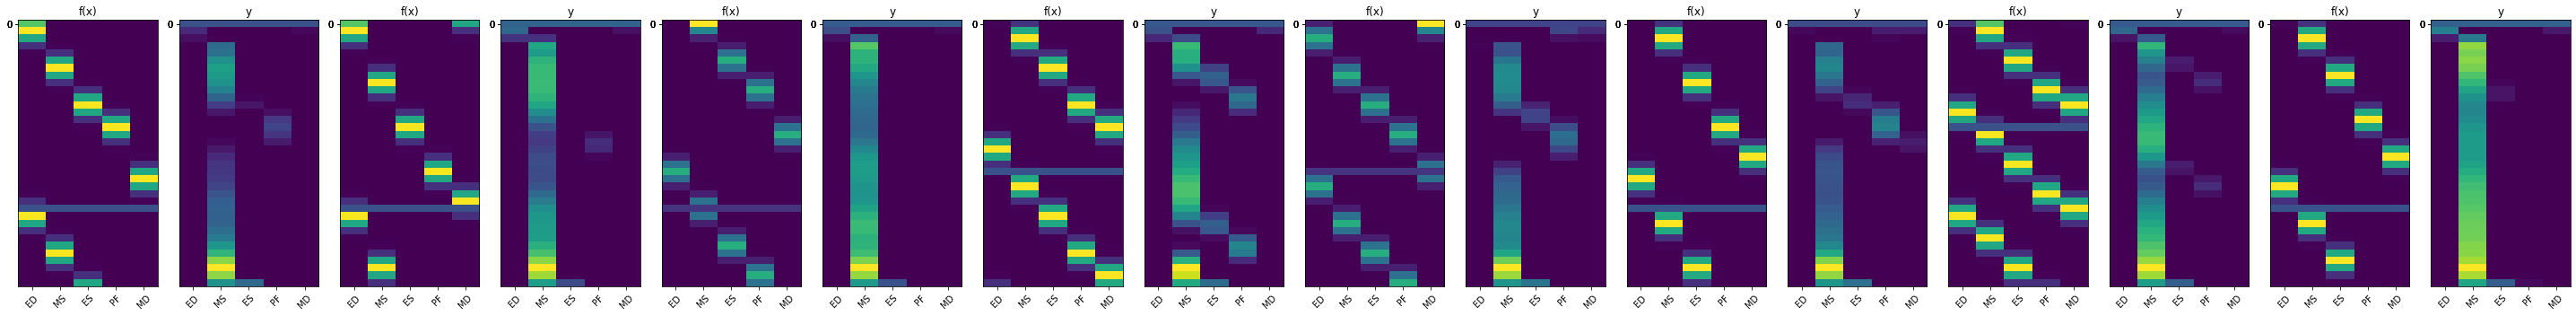

In [23]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases(pred,outputs)

In [25]:
pred.shape

TensorShape([8, 2, 36, 5])

In [14]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

24.776663

In [14]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

NameError: name 'outputs' is not defined

In [15]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

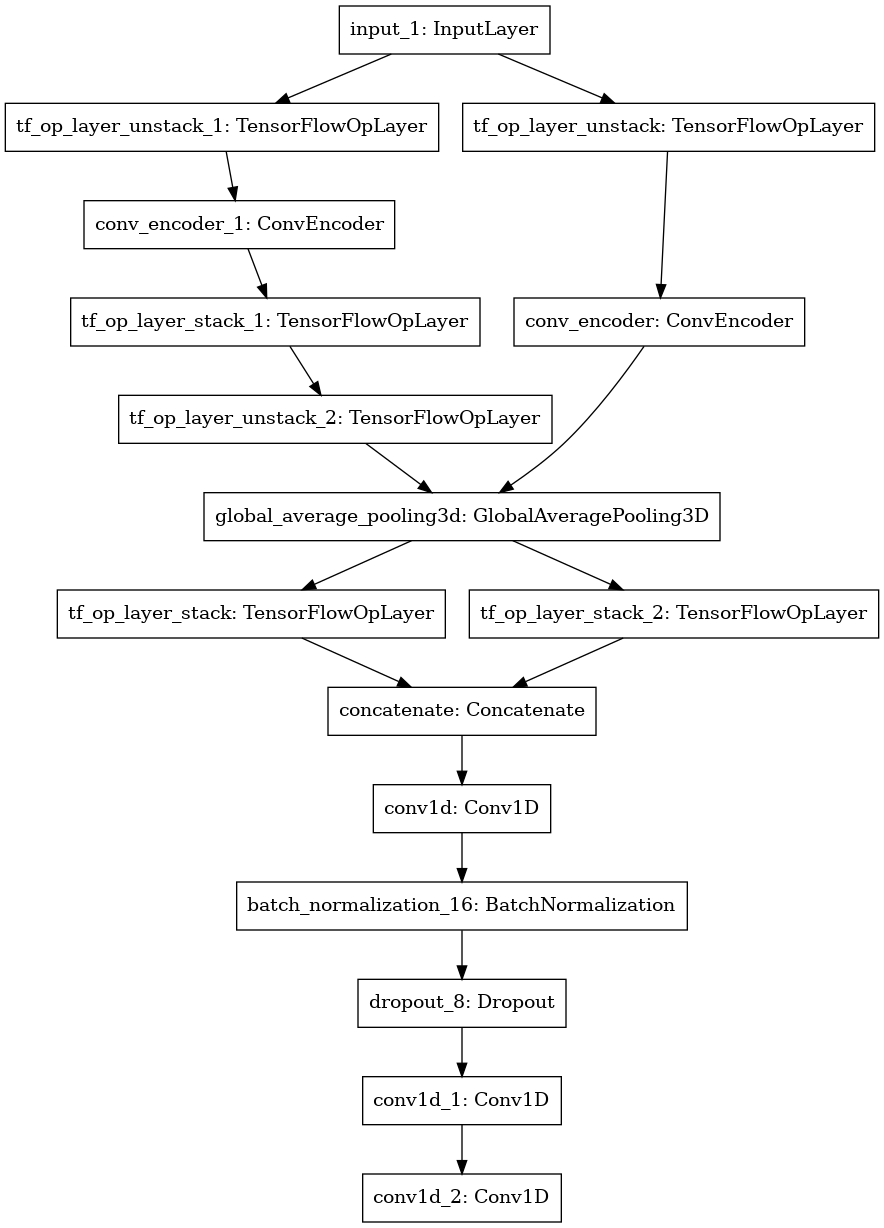

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)